In [101]:
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import *
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.metrics import log_loss, f1_score, roc_curve
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("../Data/Raw/dataset_kobe_dev.parquet")

In [3]:
df.shape

(24271, 25)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24271 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         24271 non-null  object 
 1   combined_shot_type  24271 non-null  object 
 2   game_event_id       24271 non-null  int64  
 3   game_id             24271 non-null  int64  
 4   lat                 24271 non-null  float64
 5   loc_x               24271 non-null  int64  
 6   loc_y               24271 non-null  int64  
 7   lon                 24271 non-null  float64
 8   minutes_remaining   24271 non-null  int64  
 9   period              24271 non-null  int64  
 10  playoffs            24271 non-null  int64  
 11  season              24271 non-null  object 
 12  seconds_remaining   24271 non-null  int64  
 13  shot_distance       24271 non-null  int64  
 14  shot_made_flag      20285 non-null  float64
 15  shot_type           24271 non-null  object 
 16  shot

In [5]:
df.isnull().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        3986
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
shot_id                  0
dtype: int64

In [6]:
columnasImportantes = ['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance']
df_filtrado = df[df['shot_made_flag'].notnull()]
df_filtrado = df_filtrado[df_filtrado['shot_type'] == '2PT Field Goal']

#Deixa no dataframe somente as colunas importantes
df_filtrado = df_filtrado[columnasImportantes]

<AxesSubplot: >

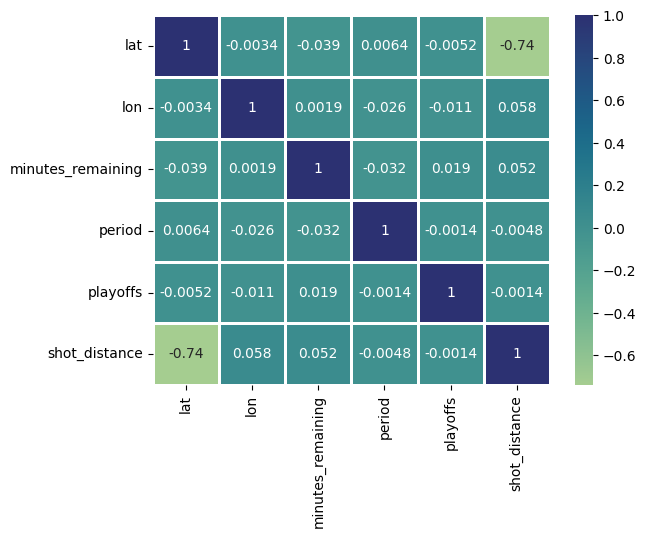

In [19]:
sns.heatmap(df_filtrado.corr(), annot=True, linewidths=1, cmap='crest')

In [20]:
df_filtrado2 = df[df['shot_made_flag'].notnull()]
df_filtrado2 = df_filtrado2[df_filtrado2['shot_type'] == '2PT Field Goal']
df_filtrado2 = df_filtrado2[['lat', 'lon', 'minutes_remaining', 'period', 'playoffs', 'shot_distance', 'shot_made_flag']]

#sns.pairplot(df_filtrado2, hue='shot_made_flag')

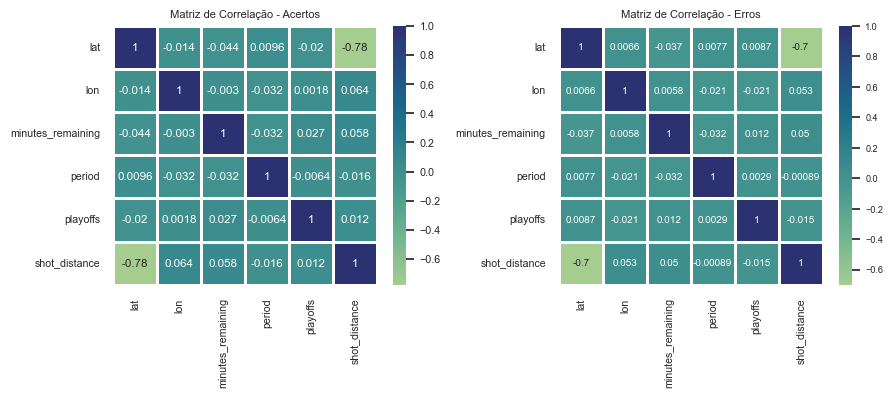

In [46]:
dfCertos = df_filtrado2[df_filtrado2["shot_made_flag"] == 1]
dfErros = df_filtrado2[df_filtrado2["shot_made_flag"] == 0]

dfCertos = dfCertos.drop('shot_made_flag', axis=1)
dfErros = dfErros.drop('shot_made_flag', axis=1)

fig, axes = plt.subplots(1, 2, figsize=(9,4))
axes[0].set_title('Matriz de Correlação - Acertos', fontsize=8)
sns.heatmap(dfCertos.corr(), annot=True, linewidths=1, cmap='crest', ax=axes[0])
sns.set(font_scale=0.6)
axes[1].set_title('Matriz de Correlação - Erros', fontsize=8)
sns.heatmap(dfErros.corr(), annot=True, linewidths=1, cmap='crest', ax=axes[1])
sns.set(font_scale=0.6)
fig.tight_layout()
fig.show()

In [47]:
#Carrega os dados de treino e teste
data_train = pd.read_parquet('../Data/Processed/base_train.parquet')
data_test = pd.read_parquet('../Data/Processed/base_test.parquet')

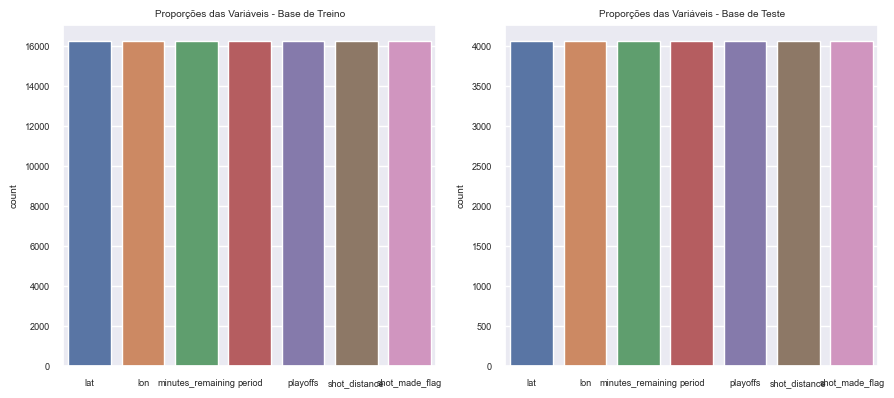

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))
sns.countplot(data=data_train, ax=axes[0]);
axes[0].set_title('Proporções das Variáveis - Base de Treino')
sns.countplot(data=data_test, ax=axes[1]);
axes[1].set_title('Proporções das Variáveis - Base de Teste')
fig.tight_layout()
fig.show()

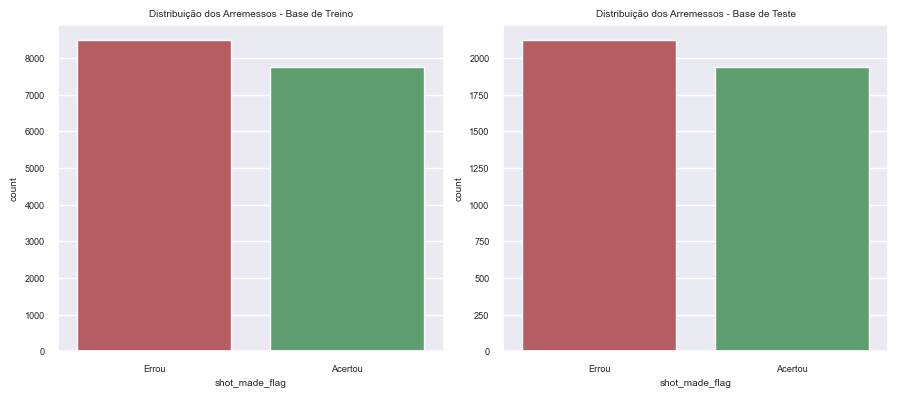

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.countplot(x='shot_made_flag', data=data_train, ax=axes[0], palette=['r','g']);
axes[0].set_xticks(ticks=[0, 1], labels=['Errou', 'Acertou'])
axes[0].set_title('Distribuição dos Arremessos - Base de Treino')

sns.countplot(x='shot_made_flag', data=data_test, ax=axes[1], palette=['r','g']);
axes[1].set_xticks(ticks=[0, 1], labels=['Errou', 'Acertou'])
axes[1].set_title('Distribuição dos Arremessos - Base de Teste')

fig.tight_layout()
fig.show()

In [75]:
#Usando pycaret
setup(data=data_train, target='shot_made_flag')

,Description,Value
0,Session id,1384
1,Target,shot_made_flag
2,Target type,Binary
3,Original data shape,"(16228, 7)"
4,Transformed data shape,"(16228, 7)"
5,Transformed train set shape,"(11359, 7)"
6,Transformed test set shape,"(4869, 7)"
7,Numeric features,6
8,Preprocess,True
9,Imputation type,simple


In [78]:
lr_model = create_model('lr')
#Faz a predição do modelo
lr_predicao = predict_model(lr_model, data=data_test)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5907,0.5984,0.4954,0.5848,0.5364,0.1744,0.1764
1,0.5986,0.6235,0.5120,0.5928,0.5494,0.1910,0.1926
2,0.5775,0.5898,0.4668,0.5698,0.5132,0.1464,0.1487
3,0.6004,0.6165,0.5111,0.5944,0.5496,0.1941,0.1959
4,0.5819,0.6139,0.4945,0.5714,0.5302,0.1570,0.1583
5,0.5819,0.5964,0.4815,0.5736,0.5236,0.1560,0.1579
6,0.5748,0.5945,0.4908,0.5624,0.5241,0.1431,0.1442
7,0.5775,0.5990,0.4760,0.5683,0.5181,0.1471,0.1489
8,0.5775,0.5863,0.4797,0.5677,0.5200,0.1474,0.1490


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.5773,0.5934,0.4972,0.5651,0.5290,0.1484,0.1494


In [80]:
evaluate_model(lr_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [81]:
dt_model = create_model('dt')
#Faz a predição do modelo
dt_predicao = predict_model(dt_model, data=data_test)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.5458,0.5335,0.5930,0.5219,0.5552,0.0950,0.0958
1,0.5431,0.5228,0.5985,0.5192,0.5560,0.0904,0.0913
2,0.5528,0.5427,0.5941,0.5279,0.5590,0.1087,0.1094
3,0.5299,0.5155,0.5554,0.5067,0.5299,0.0618,0.0621
4,0.5511,0.5320,0.5941,0.5261,0.5581,0.1053,0.1061
5,0.5493,0.5295,0.5756,0.5253,0.5493,0.1005,0.1009
6,0.5343,0.5185,0.5886,0.5104,0.5467,0.0729,0.0737
7,0.5414,0.5189,0.5941,0.5169,0.5528,0.0868,0.0877
8,0.5326,0.5166,0.5664,0.5091,0.5362,0.0678,0.0682


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.5393,0.5250,0.5756,0.5157,0.5440,0.0814,0.0819


In [82]:
evaluate_model(dt_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [87]:
#Pesquisando o melhor modelo
best_model = compare_models(n_select = 1, sort='Accuracy')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.5915,0.5991,0.3731,0.6203,0.4657,0.1670,0.1813,0.0310
gbc,Gradient Boosting Classifier,0.5885,0.5971,0.3844,0.6093,0.4712,0.1619,0.1735,0.0750
lr,Logistic Regression,0.5823,0.5993,0.4891,0.5732,0.5278,0.1575,0.1591,0.1840
ridge,Ridge Classifier,0.5804,0.0000,0.4906,0.5704,0.5274,0.1540,0.1554,0.0070
lda,Linear Discriminant Analysis,0.5802,0.6009,0.4910,0.5701,0.5275,0.1537,0.1551,0.0080
nb,Naive Bayes,0.5780,0.5982,0.5114,0.5639,0.5364,0.1507,0.1514,0.2480
qda,Quadratic Discriminant Analysis,0.5770,0.6005,0.5373,0.5592,0.5479,0.1508,0.1509,0.0050
lightgbm,Light Gradient Boosting Machine,0.5708,0.5858,0.4779,0.5590,0.5151,0.1344,0.1358,0.4030
rf,Random Forest Classifier,0.5613,0.5694,0.5258,0.5415,0.5335,0.1197,0.1198,0.1320
et,Extra Trees Classifier,0.5497,0.5608,0.5371,0.5279,0.5324,0.0982,0.0983,0.1290


In [88]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

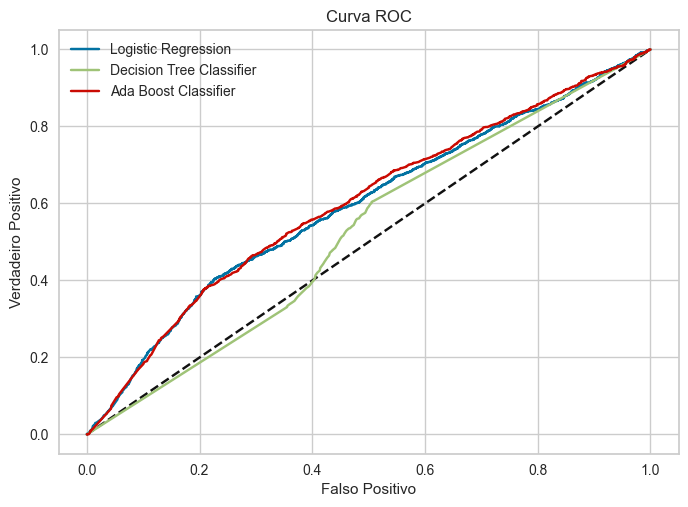

In [113]:
#Monta a curva ROC
X_test = data_test.drop('shot_made_flag', axis=1)
Y_test = data_test['shot_made_flag']

y_pred_prob1 = lr_model.predict_proba(X_test)[:,1]
fpr1 , tpr1, thresholds1 = roc_curve(Y_test, y_pred_prob1)

y_pred_prob2 = dt_model.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(Y_test, y_pred_prob2)

y_pred_prob3 = best_model.predict_proba(X_test)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(Y_test, y_pred_prob3)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Logistic Regression")
plt.plot(fpr2, tpr2, label= "Decision Tree Classifier")
plt.plot(fpr3, tpr3, label= "Ada Boost Classifier") #Adicionado a parte no projeto
plt.legend()
plt.xlabel("Falso Positivo")
plt.ylabel("Verdadeiro Positivo")
plt.title('Curva ROC')
plt.show()